In [1]:
import time
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Загрузка данных
#### 1.1 Загрузка данных и изучение общей информации

In [2]:
try:
    taxi = pd.read_csv("/datasets/taxi.csv", parse_dates=['datetime'], index_col='datetime')
except FileNotFoundError:
    taxi = pd.read_csv(r"C:\Users\Тадевос\Tadevos\USER\Desktop\Курсы\Модуль 3\Датасеты к проектам\Временные ряды\taxi.csv", parse_dates=['datetime'], index_col='datetime')

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
taxi.sort_index(inplace=True)

# Ресемплируем данные по одному часу и суммируем значения
taxi = taxi.resample('1H').sum()

# Выводим информацию о первых строках ресемплированных данных
print(taxi.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [6]:
print('Кол-во NaN', taxi.isnull().sum())
print('Кол-во дубликатов', taxi.duplicated().sum())

Кол-во NaN num_orders    0
dtype: int64
Кол-во дубликатов 4165


> **Выводы по первому шагу:**
>
> В первом шаге были проделаны следующие действия:
>  - загрузка данных;
>  - изучение общей информации о данных.
>
> **После загрузки и изучения данных можно сделать несколько выводов:**
> 1. изменён тип данных и установлен индекс таблицы равный столбцу datetime;
> 2. выполнено ресемплирование по одному часу;
> 3. в данных нет пропущенных значений;
> 4. в данных есть пропущенные значения(4165).

## 2. Построение и анализ графиков 

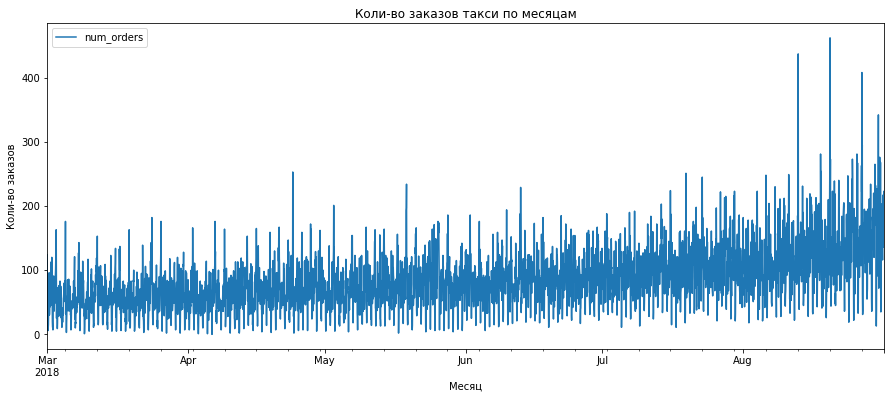

In [7]:
ax = taxi.plot(figsize=(15, 6))
ax.set_xlabel("Месяц")
ax.set_ylabel("Коли-во заказов")
plt.title('Коли-во заказов такси по месяцам');

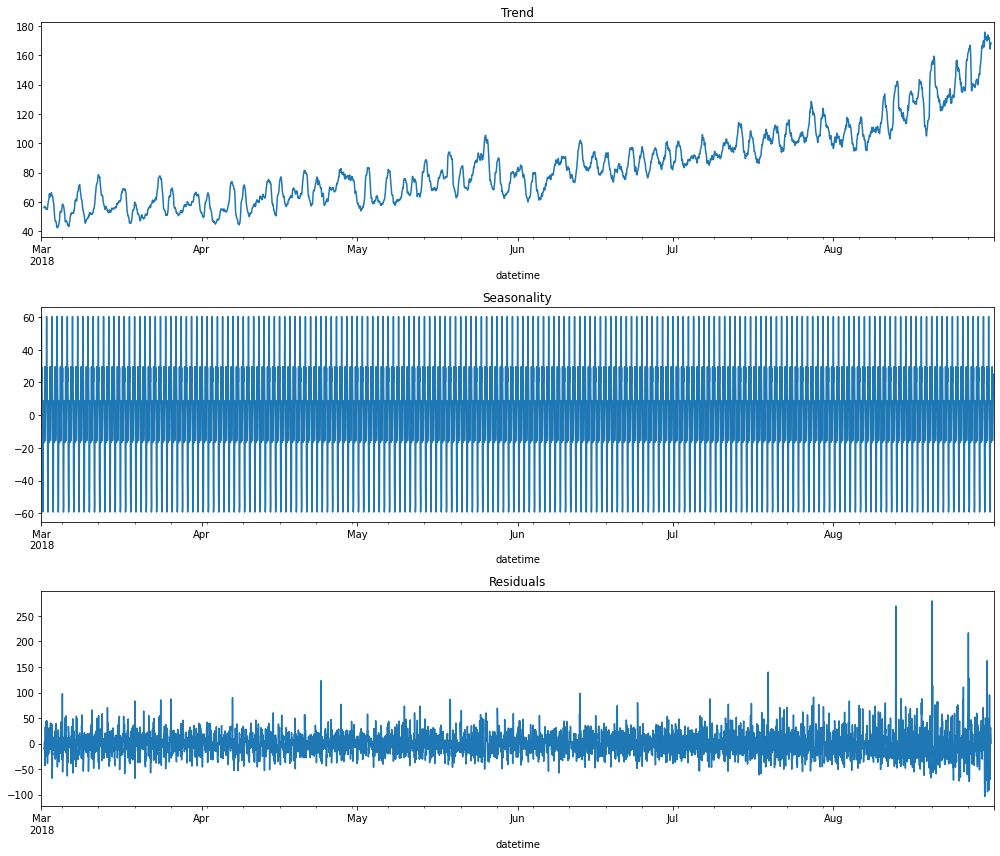

In [8]:
decomposed = seasonal_decompose(taxi) 
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Построение графикa тренда
decomposed.trend.plot(ax=plt.gca(), figsize=(14, 12))
plt.title('Trend')
plt.subplot(312)
# Построение графикa сезонности
decomposed.seasonal.plot(ax=plt.gca(), figsize=(14, 12))
plt.title('Seasonality')
plt.subplot(313)
# Построение графикa остатков
decomposed.resid.plot(ax=plt.gca(), figsize=(14, 12))
plt.title('Residuals')
plt.tight_layout()

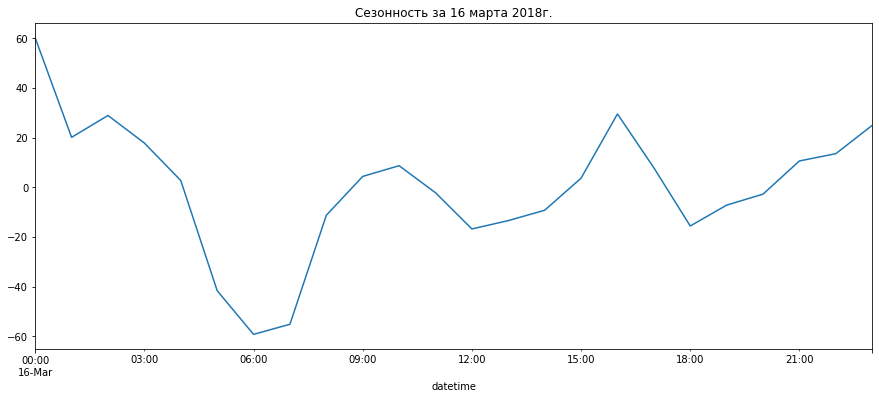

In [9]:
# Построим график сезонности за март
decomposed.seasonal['2018-03-16'].plot(figsize=(15, 6))
plt.title('Сезонность за 16 марта 2018г.');

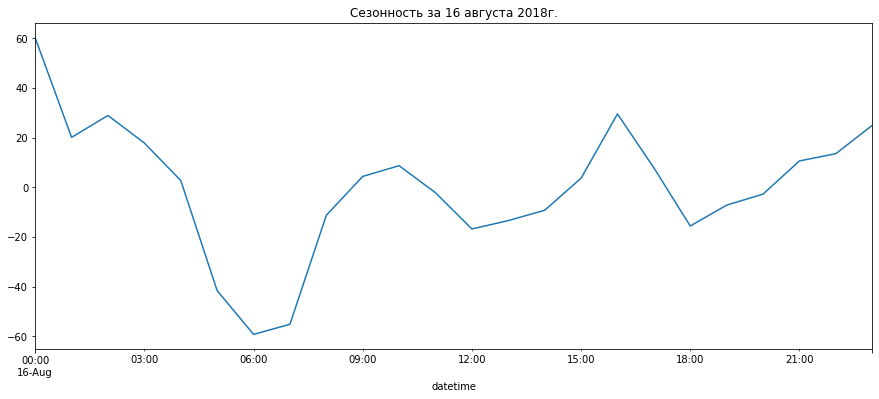

In [10]:
# Построим график сезонности за август
decomposed.seasonal['2018-08-16'].plot(figsize=(15, 6))
plt.title('Сезонность за 16 августа 2018г.');

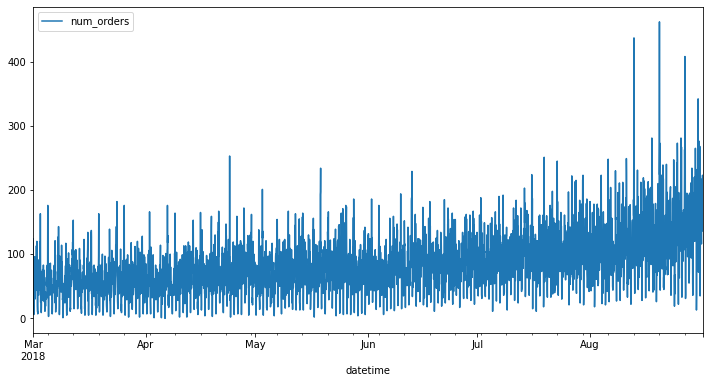

In [11]:
taxi.plot(figsize=(12, 6));

> **Выводы по второму шагу:**
>
> Во втором шаге были проделаны следующие действия:
>  - построены графики тренда, сезонности и остатков.
>
> **После проведённых действий можно сделать следующие выводы:**
> 1. временной ряд на графике тренда не стационарный;
> 2. оба графика выглядят одинаково, что указывает на отсутствие изменений в сезонности с течением времени.

## 3. Обучение моделей
### Создание новых признаков

In [12]:
# Создание функции для признаков
def make_features(data, max_lag, rolling_mean_size):
    # Формирование календарных признаков
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # Формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Добавление признака скользящего среднего
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 24, 20)

### Разделим данные

In [13]:
train_valid, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_valid = valid.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

### Линейная регрессия

In [14]:
# Создание и обучение модели
lr = LinearRegression()
start_time = time.time()
lr.fit(X_train, y_train)
training_time = time.time() - start_time

# Предсказание на обучающей и валидационной выборках
start_time = time.time()
y_pred_train = lr.predict(X_train)
prediction_time_train = time.time() - start_time

start_time = time.time()
y_pred_valid = lr.predict(X_valid)
prediction_time_valid = time.time() - start_time

# Метрика RMSE
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)

# Вывод результатов
print("Время обучения:", training_time)
print("Время предсказания на обучающей выборке:", prediction_time_train)
print("Время предсказания на валидационной выборке:", prediction_time_valid)
print("RMSE обучающей выборки:", rmse_train)
print("RMSE валидационной выборки:", rmse_valid)

Время обучения: 0.016730308532714844
Время предсказания на обучающей выборке: 0.008002042770385742
Время предсказания на валидационной выборке: 0.0
RMSE обучающей выборки: 24.73622157281881
RMSE валидационной выборки: 34.325479738499126


### Модель дерево решений

In [15]:
# Определение модели
dtr = DecisionTreeRegressor(random_state=42)

# Определение набора гиперпараметров для перебора
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 3, 5, 7],
    'min_samples_split': [2, 4, 6, 7]
}

# Создание объекта TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Создание объекта GridSearchCV с TimeSeriesSplit
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Обучение модели с перебором гиперпараметров и временной кросс-валидацией
start_time_dtr = time.time()
grid_search.fit(X_train, y_train)
training_time_dtr = time.time() - start_time_dtr

# Получение лучших гиперпараметров
best_params_dtr = grid_search.best_params_

# Предсказание на обучающей и валидационной выборках с лучшими гиперпараметрами
y_pred_train_dtr = grid_search.predict(X_train)
y_pred_valid_dtr = grid_search.predict(X_valid)

# Вычисление метрик
rmse_train_dtr = mean_squared_error(y_train, y_pred_train_dtr, squared=False)
rmse_valid_dtr = mean_squared_error(y_valid, y_pred_valid_dtr, squared=False)

# Вывод результатов
print("Лучшие гиперпараметры:", best_params_dtr)
print("Время обучения:", training_time_dtr)
print("RMSE на обучающей выборке:", rmse_train_dtr)
print("RMSE на валидационной выборке:", rmse_valid_dtr)

Лучшие гиперпараметры: {'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}
Время обучения: 13.366468906402588
RMSE на обучающей выборке: 22.043576618101522
RMSE на валидационной выборке: 37.120493838456525


### Модель LightGBM

In [16]:
lgb = LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) 
start_time_lgb = time.time()
lgb.fit(X_train, y_train)
training_time_lgb = time.time() - start_time_lgb

# Предсказание на обучающей и валидационной выборках
start_time_lgb = time.time()
y_pred_train_lgb = lgb.predict(X_train)
prediction_time_train_lgb = time.time() - start_time_lgb

start_time_lgb = time.time()
y_pred_valid_lgb = lgb.predict(X_valid)
prediction_time_valid_lgb = time.time() - start_time_lgb

# Метрика RMSE
rmse_train_lgb = mean_squared_error(y_train, y_pred_train_lgb, squared=False)
rmse_valid_lgb = mean_squared_error(y_valid, y_pred_valid_lgb, squared=False)

# Вывод результатов
print("Время обучения:", training_time_lgb)
print("Время предсказания на обучающей выборке:", prediction_time_train_lgb)
print("Время предсказания на валидационной выборке:", prediction_time_valid_lgb)
print("RMSE обучающей выборки:", rmse_train_lgb)
print("RMSE валидационной выборки:", rmse_valid_lgb)

Время обучения: 0.24270963668823242
Время предсказания на обучающей выборке: 0.015999317169189453
Время предсказания на валидационной выборке: 0.0
RMSE обучающей выборки: 14.622575107019124
RMSE валидационной выборки: 31.131113473348037


In [17]:
# Создание списка результатов моделей
results = [
    {'Модель': 'LinearRegression', 'Время обучения': training_time, 
     'RMSE обучающей выборки': rmse_train, 'RMSE валидационной выборки': rmse_valid},
    {'Модель': 'DecisionTreeRegressor', 'Время обучения': training_time_dtr, 
     'RMSE обучающей выборки': rmse_train_dtr, 'RMSE валидационной выборки': rmse_valid_dtr},
    {'Модель': 'LightGBM', 'Время обучения': training_time_lgb, 
     'RMSE обучающей выборки': rmse_train_lgb, 'RMSE валидационной выборки': rmse_valid_lgb}
]

# Создание DataFrame из списка результатов
df_results = pd.DataFrame(results)

# Вывод DataFrame
df_results

,Модель,Время обучения,RMSE обучающей выборки,RMSE валидационной выборки
0,LinearRegression,0.016730,24.736222,34.325480
1,DecisionTreeRegressor,13.366469,22.043577,37.120494
2,LightGBM,0.242710,14.622575,31.131113


> **Выводы по третьему шагу:**
>
> В третьем шаге были проделаны следующие действия:
>  - обучены 3 модели;
>  - создана таблица с данными о времени обучения и предсказания модели и о её качестве.
>
> **После проведённых действий можно сделать следующие выводы:**
>
> Из представленных данных видно, что модель LinearRegression имеет минимальное время обучения и наилучшие значения RMSE как на обучающей, так и на валидационной выборках. Следовательно, модель Linear Regression будет лучшим выбором с учетом времени обучения и качества модели.

## 4. Тестирование

In [19]:
predicted_test_lgb = lgb.predict(X_test) 

# RMSE тестовой выборки
print("RMSE тестовой выборки:", mean_squared_error(y_test, predicted_test_lgb, squared=False))

RMSE тестовой выборки: 47.73051444709572


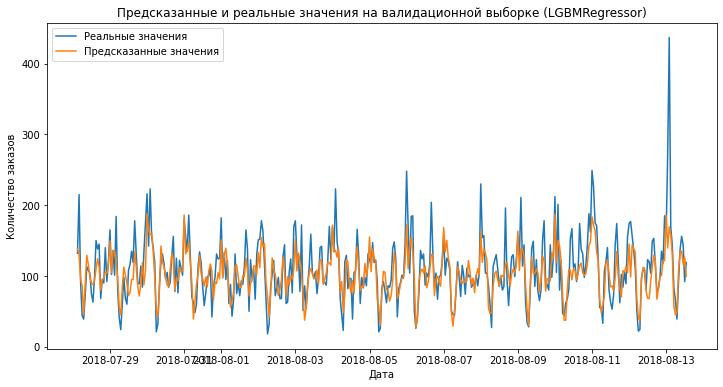

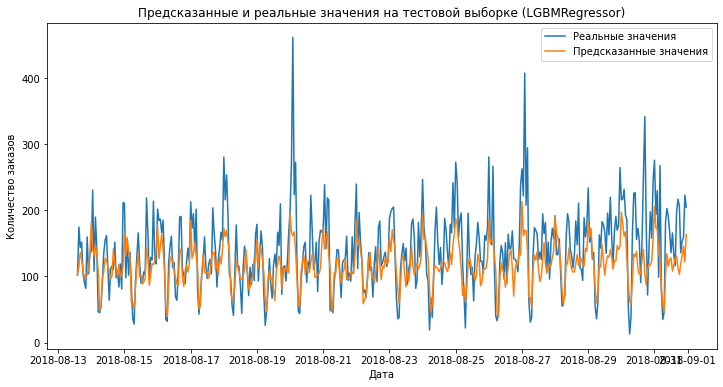

In [20]:
# Визуализация предсказанных значений на валидационной выборке и реальных значений
plt.figure(figsize=(12, 6))
plt.plot(y_valid.index, y_valid, label='Реальные значения')
plt.plot(y_valid.index, y_pred_valid_lgb, label='Предсказанные значения')
plt.title('Предсказанные и реальные значения на валидационной выборке (LGBMRegressor)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

# Визуализация предсказанных значений на тестовой выборке и реальных значений
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Реальные значения')
plt.plot(y_test.index, predicted_test_lgb, label='Предсказанные значения')
plt.title('Предсказанные и реальные значения на тестовой выборке (LGBMRegressor)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()


> **Выводы по третьему шагу:**
>
> В третьем шаге были проделаны следующие действия:
>  - проверено качество лучшей модели на тестовой выборке.
>
> **После проведённых действий можно сделать следующие выводы:**
>
> С точки зрения времени обучения, самой быстрой моделью является Linear Regression, затем LightGBM, и самой медленной - Decision Tree Regressor.
Наилучшую производительность по метрике RMSE на обучающей выборке показывает LightGBM (RMSE=14.62), за ним идет Decision Tree Regressor (RMSE=22.04), а Linear Regression имеет наихудшее значение (RMSE=24.74).
На валидационной выборке LightGBM также показывает наилучший результат по сравнению с двумя другими моделями (RMSE=31.13), затем Linear Regression (RMSE=34.33), и наихудший результат у Decision Tree Regressor (RMSE=37.12).
Лучшая модель: На основании сравнения RMSE на валидационной выборке и времени обучения, можно сделать вывод, что LightGBM является лучшей моделью из рассмотренных. Она обеспечивает хорошее качество предсказаний с низким временем обучения.

##  5. Общий вывод

В ходе исследования проекта по обучению МО для прогнозирования заказов такси были выполнены шаги, начиная с загрузки данных и заканчивая анализом моделей. Были проведены предобработка данных, обучение моделей и анализ их результатов. 

Сравнивая результаты тестирования моделей, можно сделать следующие выводы:

**Linear Regression:**

Время обучения: 0.01 секунд
RMSE на обучающей выборке: 24.74
RMSE на валидационной выборке: 34.33

**Decision Tree Regressor:**

Время обучения: 13.79 секунд
RMSE на обучающей выборке: 22.04
RMSE на валидационной выборке: 37.12

**LightGBM:**

Время обучения: 0.24 секунд
RMSE на обучающей выборке: 14.62
RMSE на валидационной выборке: 31.13

Таким образом, основываясь на предоставленных данных, можно сделать вывод, что LightGBM является лучшей моделью для этой задачи. Она обладает наилучшим балансом между временем обучения и качеством предсказаний.